# Docker Example: ETDRS Analysis stratified by vessel size

This jupyter notebook shows how to quantitatively analyze a dataset of OCTA images using our graph extraction pipeline. In the end, we will be able to compare vessel density of a dataset stratified by vessel size and by sector in the ETDRS grid.

We will only use the provided docker file for this. We only import a few dependencies to visualize our data in this notebook.

## Prerequisites

- [Docker](https://www.docker.com/) installation
- A dataset of OCTA images. The DVC must be present in the images or in a separate image file

## 1. Installation

In this tutorial we will use the provided docker image to avoid the elaborate manual installation of Voreen. So let us start by building the docker image:

In [ ]:
# Build Docker image. (This can take a while. Only required once.)
!docker build . -t octa-graph-extraction

Import the necessary libraries:

In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import colorConverter
import matplotlib as mpl

from natsort import natsorted
from glob import glob
from PIL import Image
import numpy as np

import os
import pandas as pd

## 2. Dataset preperation

### 2.1 Dataset visualization

Let us have a look at our dataset first:

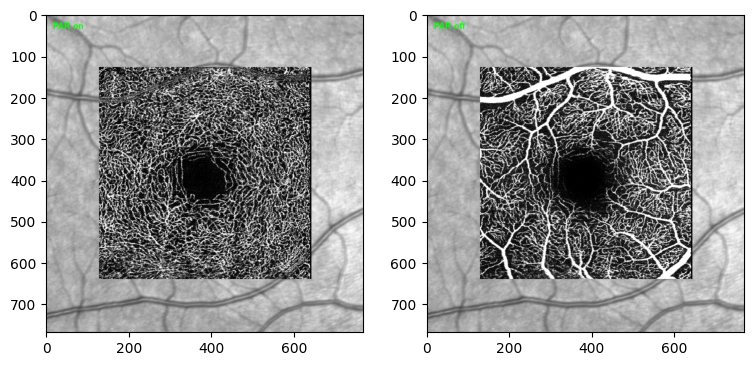

In [2]:
path_to_OCTA_images: str = ... # TODO Absolute path to the folder containing your OCTA images

image_paths = natsorted(glob(path_to_OCTA_images, recursive=True))
assert len(image_paths)>0, f"No files found for path {path_to_OCTA_images}"

_, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(9,5))
ax1.imshow(Image.open(image_paths[0]), cmap="gray")
ax2.imshow(Image.open(image_paths[1]), cmap="gray")

### 2.2 ROI cropping (Optional)

If your images are imbedded in a fundus image, you can use our provided script for ROI_cropping:

In [8]:
INPUT_DIR=...# TODO Absolute path to your parent folder containing all images
OUTPUT_DIR=...# TODO Absolute path to your parent folder containing all images
!docker run -v $INPUT_DIR:/var/images -v $OUTPUT_DIR:/var/results octa-graph-extraction roi

[Info] Mode: roi
100%|██████████| 238/238 [00:04<00:00, 49.95it/s]


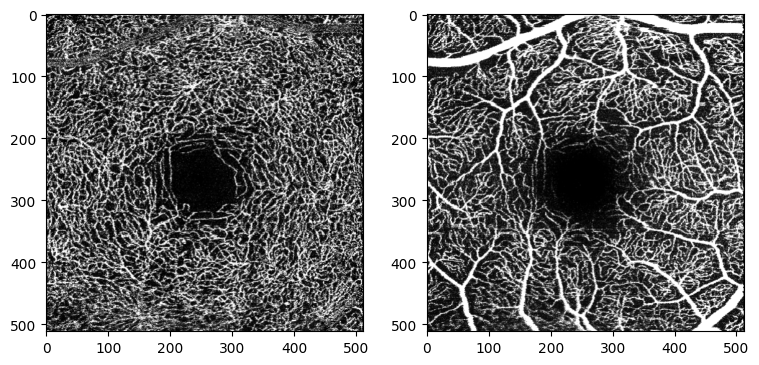

In [8]:
path_to_OCTA_images: str = ... # ".../*.png" # TODO Absolute path to the folder containing your OCTA images

image_paths = natsorted(glob(path_to_OCTA_images, recursive=True))
assert len(image_paths)>0, f"No files found for path {path_to_OCTA_images}"

_, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(9,5))
ax1.imshow(Image.open(image_paths[0]), cmap="gray")
ax2.imshow(Image.open(image_paths[1]), cmap="gray")

### 2.3 Segmentation

Check out [our tool for OCTA segmentation](https://github.com/TUM-AIMED/OCTA-seg) and create the segmentation maps for your dataset. If the provided pre-trained model does not offer good performance for your dataset, you can train your own. Check out our example jupyter notebooks! 

**After** you segmented your images, you can visualize them running the cell below.

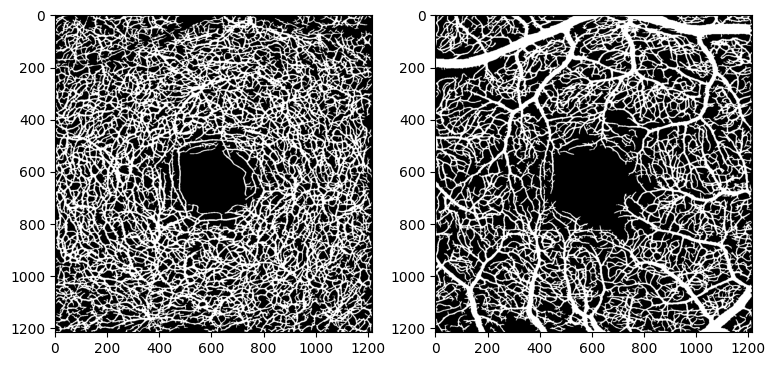

In [101]:
path_to_segmentations: str = ... # ".../*.png" # TODO Absolute path to the folder containing your segmentation maps

image_paths = natsorted(glob(path_to_segmentations, recursive=True))
assert len(image_paths)>0, f"No files found for path {path_to_segmentations}"

_, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(9,5))
ax1.imshow(Image.open(image_paths[0]), cmap="gray")
ax2.imshow(Image.open(image_paths[1]), cmap="gray")

### 2.4 3D Reconstruction (Optional)

For a more acurate analysis, we recommend to create a 3D reconstruction of your 2D segmentation map. Use [our tool for 3D reconstruction](https://github.com/TUM-AIMED/OCTA-seg) to create a nifti file for your vessel segmentations.

### 2.5 FAZ segmentation

We will now use the segmentation maps of the DVC to predict a segmentation of the FAZ.

> [!IMPORTANT] Our script requires a reasonable image quality / segmentation quality for an accurate faz segmentation

In [3]:
DATASET_DIR=... # TODO Absolute path to the folder containing your DVC segmentation masks / volumes
RESULT_DIR=... # TODO Absolute path to the folder to save the faz segmentation masks to
!docker run -v $DATASET_DIR:/var/segmentations -v $RESULT_DIR:/var/faz octa-graph-extraction faz_seg

[Info] Mode: faz_seg
Segmenting FAZ...: 476it [01:39,  4.77it/s]


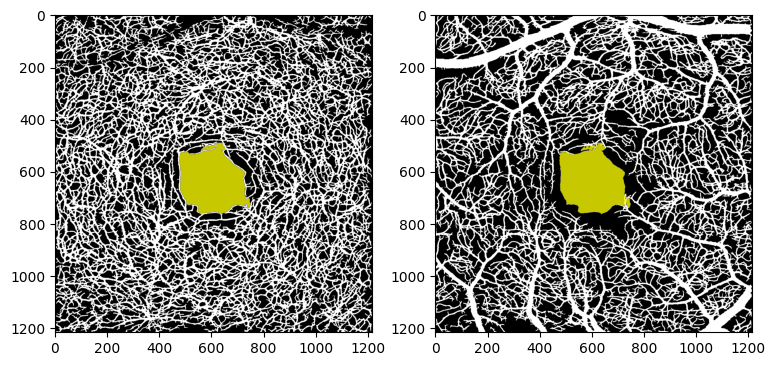

In [122]:
path_to_faz_segmentations: str = ... # .../*.png # TODO Absolute path to the folder containing your faz segmentation maps

faz_paths = natsorted(glob(path_to_faz_segmentations, recursive=True))
assert len(faz_paths)>0, f"No files found for path {path_to_faz_segmentations}"

# generate the colors for your colormap
color1 = colorConverter.to_rgba('white')
color2 = colorConverter.to_rgba('black')

# make the colormaps
cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',[color2,color1],256)
cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,"yellow"],256)

cmap2._init() # create the _lut array, with rgba values

# create your alpha array and fill the colormap with them.
# here it is progressive, but you can create whathever you want
alphas = np.linspace(0, 0.8, cmap2.N+3)
cmap2._lut[:,-1] = alphas

_, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(9,5))
ax1.imshow(Image.open(image_paths[0]), cmap=cmap1)
ax1.imshow(Image.open(faz_paths[0]), cmap=cmap2, origin="lower")
ax1.invert_yaxis()
ax2.imshow(Image.open(image_paths[1]), cmap=cmap1)
ax2.imshow(Image.open(faz_paths[0]), cmap=cmap2, origin="lower")
ax2.invert_yaxis()

## 3. Vessel graph extraction

We will now perform the vessel graph extraction. In this example, we will use the analysis using the ETDRS grid. The center of the ETDRS grid is set to the center of mass of the FAZ that we segmented in the last step. The result will be a folder for each sample containing the analysis per sector.

In [1]:
DATASET_DIR=... # TODO Absolute path to your DVC segmentation masks / volumes
FAZ_DIR=... # TODO Absolute path to your FAZ segmentations
RESULT_DIR=... # TODO Absolute path to the folder to save the graph features to
!docker run -v $DATASET_DIR:/var/segmentations -v $FAZ_DIR:/var/faz -v $RESULT_DIR:/var/results octa-graph-extraction graph_extraction_etdrs

Let us take a look at the extracted graph:

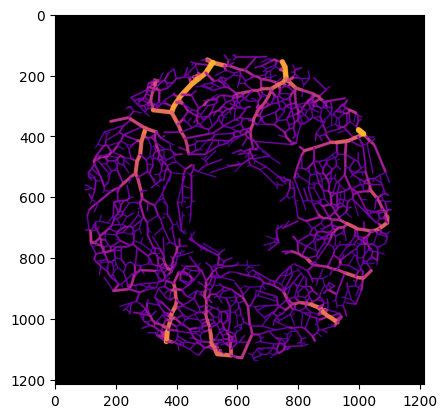

In [4]:
path_to_graph_folder: str = ... # TODO Absolute path to the folder containing your faz segmentation maps

graph_images_paths = natsorted(glob(os.path.join(path_to_graph_folder, "**/*.png"), recursive=True))
assert len(graph_images_paths)>0, f"No files found for path {path_to_graph_folder}"

c0_path, i1_path, n1_path, s1_path, t1_path = graph_images_paths[:5]
img = 0
for p in graph_images_paths[:5]:
    img += np.array(Image.open(p))
plt.imshow(img)

As we can see the vessel sizes have been correctly identified and are color coded by their size. Because we mask the segmentations, there a small gaps at the borders of the ETDRS grid.

Let us have a look at the graph features next:

In [126]:
c0_csv_path = natsorted(glob(os.path.join(path_to_graph_folder, "*.csv"), recursive=True))[0]
df = pd.read_csv(c0_csv_path, sep=";",index_col=0)
df.head()

,node1id,node2id,length,distance,curveness,volume,avgCrossSection,minRadiusAvg,minRadiusStd,avgRadiusAvg,avgRadiusStd,maxRadiusAvg,maxRadiusStd,roundnessAvg,roundnessStd,node1_degree,node2_degree,num_voxels,hasNodeAtSampleBorder
id,,,,,,,,,,,,,,,,,,,
0,69,0,11.63550,11.18030,1.04071,117,10.0555,1.50739,0.020224,2.00576,0.225641,2.70577,0.353304,0.564580,0.057880,1,3,10,0
1,70,74,3.95411,3.90159,1.01346,70,17.7031,2.01477,0.122063,3.33375,0.362315,4.59410,0.767745,0.446589,0.048062,3,3,2,0
2,76,79,5.92472,5.82140,1.01775,159,26.8367,2.51786,0.017654,3.45781,0.247752,4.21717,0.450198,0.603312,0.059129,3,3,4,0
3,7,127,9.53599,8.98145,1.06174,137,14.3666,1.51966,0.050151,2.23195,0.433898,3.06522,0.815034,0.520324,0.093422,1,3,7,0
4,79,8,8.87545,8.35994,1.06166,112,12.6191,1.29573,0.385129,2.12008,0.322228,2.92691,0.560611,0.443484,0.122996,1,3,7,0


## 4. Analysis

We will now collect all metrics of each sample to generate a analysis summary.

> [!IMPORTANT]
> The script expects your graph data to be organized in the following schema:
> - Folder structure: `.../<Group>/<ImageName>/<ImageName>_edges.csv` for etdrs or `.../Group/<ImageName>_edges.csv`
> - `<ImageName>` consist of `<ImageUUID>` and `<EyeCode>` which is either `_OS` or `_OD`
> - Path contains the `<PlexusCode>` either `SVC`/`SCP` or `DVC`/`DCP`.
> - For ETDRS analysis, the `<ImageName>` must contain the `<SectorCode>` (`C0`, `S1`, `N1`, `I1`, `T1`)

In [7]:
GRAPH_FILES_DIR=... # TODO Absolute path to the folder containing all graph extraction files
FAZ_DIR=... # "'../*.png'" TODO Absolute path to the folder containing your FAZ segmnetation files.
RESULT_DIR=... # TODO Absolute path to the output folder
!docker run -v $GRAPH_FILES_DIR:/var/graph_files -v $FAZ_DIR:/var/faz -v $RESULT_DIR:/var/results octa-graph-extraction analysis --mm 3 --etdrs --from_3d

[Info] Mode: analysis
100%|██████████| 2363/2363 [00:05<00:00, 415.31it/s]


Let us now have a look at the summary file:

In [3]:
summary_file_path: str = ... # ".../density_measurements_etdrs.csv" TODO Absolute path to your summary file
df = pd.read_csv(summary_file_path)
df.head()

,Image_ID,Group,Eye,Layer,FAZ area [mm²],C0 Density (radius < 5µm) [%],C0 Density (5µm < radius) [%],S1 Density (radius < 5µm) [%],S1 Density (5µm < radius) [%],N1 Density (radius < 5µm) [%],N1 Density (5µm < radius) [%],I1 Density (radius < 5µm) [%],I1 Density (5µm < radius) [%],T1 Density (radius < 5µm) [%],T1 Density (5µm < radius) [%]
0,MyImageID_0,MY_GROUP,OD,DVC,0.104308,6.616846,17.305548,11.542945,41.567457,11.200493,37.834652,8.664737,44.400544,9.010089,41.800878
1,MyImageID_1,MY_GROUP,OS,SVC,0.123611,4.887872,5.676774,10.760957,30.727584,9.102116,27.769544,9.152853,34.004087,9.930666,26.116810
2,MyImageID_2,MY_GROUP,OD,SVC,0.104308,5.866325,6.645845,9.253617,33.028488,10.810521,26.831931,13.628508,27.628379,10.706843,24.772679
3,MyImageID_3,MY_GROUP,OS,DVC,0.123611,5.789001,15.774529,8.873267,42.757786,11.134787,37.879928,11.455157,38.587265,7.340093,47.285918
4,MyImageID_4,MY_GROUP,OS,SVC,0.160956,0.591179,0.733094,9.019979,25.687633,8.716270,22.026364,9.066654,26.615258,8.444810,24.051326


> [!NOTE]
> A few notes on the radii prediction:
> - When using a 2D segmentation map instead of a 3D one, the radius is often underestimated. This is especially pronounced for large vessels
> - When using our standard resolution of 1216x1216 pixel for a 3mm² area, the radii of the smallest vessel are often overestimated. This is because of the limited resolution
> - Absolute values of the radii are difficult to verify. We recommend to mainly use relative comparisons, e.g. Patients from cohortA have a lower vessel density for small vessels than patients from cohortB

## What's next?

Congratulations, you made it trough the example! 🎉

You can now start to optimize your pipeline. Possible things you might want to try next:
- Use 3D reconstruction if you have not tried it before. See our [3d reconstruction tool](https://github.com/TUM-AIMED/OCTA-seg#3-generate-a-3d-reconstruction-of-your-2d-segmentation-map-results-will-be-given-as-nifti-file)
- Improve you vessel segmentation. See our [vessel segmentation tool](https://github.com/TUM-AIMED/OCTA-seg#1-to-segment-a-set-of-images-replace-the-placeholders-with-your-directory-paths-and-run)
- Play around with the different features provided by voreen e.g., vessel curveness, etc.